# MLFlow runs

In [130]:
import mlflow
from mlflow.tracking import MlflowClient
import itertools
import matplotlib.pyplot as plt
from mlflow.entities import ViewType

mlflow.tracking.set_tracking_uri('../mlruns')

## Functions

In [3]:
def get_runs(experiment_name, filter_string=''):
    client = MlflowClient()
    exp_ids = [client.get_experiment_by_name(experiment_name).experiment_id]
    runs = mlflow.search_runs(experiment_ids=exp_ids, filter_string=filter_string)
    return runs


def get_best_run(runs, best_metrics):
    if runs is None or runs.shape[0] == 0:
        return None
    for metric in best_metrics:
        runs = runs.loc[runs[f'metrics.{metric}'] >= runs[f'metrics.{metric}'].max()]
    # pick first in the list
    run = runs.loc[runs.index[0]]
    return run

In [4]:
def runs_to_latex(runs, threshold_method, caption, label, grouped=False):
    cols = ['tags.mlflow.runName', 'tags.model', 'tags.method', 'metrics.test_auc', 'metrics.test_tax_yield', 'metrics.test_tax_score', 'metrics.test_effort', 'metrics.test_f1-score_1', 'metrics.test_recall_1', 'metrics.test_precision_1', 'metrics.threshold']
    cols_renamed = [ 'name', 'model', 'method', 'auc', 'yield', 'value', 'effort', 'f1-score', 'recall', 'precision', 'threshold' ]
    to_replace = {
        'model': {'tree': 'DT', 'forest': 'RF', 'logit': 'LR'},
        'method': {'imbalanced': 'IM', 'oversample': 'RO', 'weighted': 'BC'}}
    df = runs.loc[:, :]
    df = df.loc[df['tags.threshold_method']==threshold_method]
    df = df.loc[df['tags.grouped']==str(grouped)]
    df = df.sort_index(ascending=False)
    df = df.loc[:, cols]
    df = df.rename(columns=dict(zip(cols, cols_renamed)))
    df = df.replace(to_replace=to_replace)
    df.loc[:, 'name'] = df.model.str.cat(df.method, sep='-')
    df = df.drop(columns=['model', 'method']).set_index(['name'])
    if threshold_method=='default':
        df = df.drop(columns=['threshold'])
    else:
        df = df.drop(columns=['auc'])
    cols_max = df.columns.drop('effort').tolist()
    s = df.style.highlight_max(subset=cols_max, axis=0, props='bfseries: ;')
    s = s.highlight_min(subset='effort', axis=0, props='bfseries: ;')
    latex_table = s.to_latex(
        column_format="lrrrrrrr", position="ht", position_float="centering",
        hrules=True, label=label, caption=caption,
        multirow_align="t", multicol_align="r")
    return latex_table

In [133]:
import matplotlib.pyplot as plt

import json
import os

def get_mlflow_boxacc_prcurve(dataset='SYNTHETIC', spec='o1b', archtype='cam', iou_threshold=50):
    boxacc = {}
    prcurve = {}
    filter_string = f'tags.dataset = "{dataset}" and status = "FINISHED" and tags.architecture_type = "{archtype}"'
    runs = get_runs('wsol2', filter_string=filter_string)
    if spec:
        background_filter = spec
        runs = runs.loc[runs['tags.dataset_spec'].str.contains(background_filter)]

    for row in runs.itertuples(index=False):
        artifact_uri = row.artifact_uri
        artifact_path = artifact_uri[len('file://'):]
        config_path = os.path.join(artifact_path, 'state/config.json')
        with open(config_path) as fp:
            _config = json.load(fp)
        boxacc_path = os.path.join(artifact_path, f'data/test/box_acc_iou_{iou_threshold}.json')
        with open(boxacc_path) as fp:
            _boxacc = json.load(fp)
            values = {k: _boxacc[k] for k in ['cam_threshold', 'box_accuracy']}
            boxacc[_config['wsol_method']] = values
        prcurve_path = os.path.join(artifact_path, 'data/test/pr_curve.json')
        with open(prcurve_path) as fp:
            _prcurve = json.load(fp)
            values = {k: _prcurve[k] for k in ['precision', 'recall']}
            prcurve[_config['wsol_method']] = values
    return boxacc, prcurve

def plot_boxacc(boxacc, title):
    # plot lines
    for method, values in boxacc.items():
        plt.plot(values['cam_threshold'], values['box_accuracy'], label = method)
    plt.xlabel("CAM threshold")
    plt.ylabel("BoxAcc")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_prcurve(curve, title):
    # plot lines
    for method, values in curve.items():
        plt.plot(values['recall'], values['precision'], label = method)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend()
    plt.show()

## Reports

### MaxBoxAccV3 and PxAP

In [114]:
filter_string = 'tags.dataset = "SYNTHETIC" and status = "FINISHED" and tags.architecture_type = "vanilla"'
runs = get_runs('wsol', filter_string=filter_string)
background_filter = 'b'
runs = runs.loc[runs['tags.dataset_spec'].str.contains(background_filter)]

In [115]:
cols = ['tags.mlflow.runName', 'metrics.test_MaxBoxAccV3', 'metrics.test_PxAP']

In [116]:
runs2 = runs.loc[:, cols].sort_values(by='tags.mlflow.runName')

In [118]:
print(runs2.loc[:,['tags.mlflow.runName','metrics.test_MaxBoxAccV3']])

             tags.mlflow.runName  metrics.test_MaxBoxAccV3
12   vgg16_gradcam_synthetic_d2b                  0.320833
10   vgg16_gradcam_synthetic_d3b                  0.301667
8    vgg16_gradcam_synthetic_d4b                  0.091667
14   vgg16_gradcam_synthetic_o1b                  0.745000
4   vgg16_scorecam_synthetic_d2b                  0.430833
2   vgg16_scorecam_synthetic_d3b                  0.351667
0   vgg16_scorecam_synthetic_d4b                  0.132500
6   vgg16_scorecam_synthetic_o1b                  0.705000


In [117]:
print(runs2.loc[:,['tags.mlflow.runName','metrics.test_PxAP']])

             tags.mlflow.runName  metrics.test_PxAP
12   vgg16_gradcam_synthetic_d2b           0.395897
10   vgg16_gradcam_synthetic_d3b           0.422439
8    vgg16_gradcam_synthetic_d4b           0.131227
14   vgg16_gradcam_synthetic_o1b           0.683651
4   vgg16_scorecam_synthetic_d2b           0.538016
2   vgg16_scorecam_synthetic_d3b           0.461270
0   vgg16_scorecam_synthetic_d4b           0.215631
6   vgg16_scorecam_synthetic_o1b           0.692447


### Localization performance at varying CAM thresholds

In [5]:
path_basedir = '../train_log'
methods = ['cam', 'gradcam', 'scorecam', 'minmaxcam']

In [12]:
filter_string = 'tags.dataset = "SYNTHETIC" and status = "FINISHED" and tags.architecture_type = "cam"'
runs = get_runs('wsol2', filter_string=filter_string)
background_filter = 'o1b'
runs = runs.loc[runs['tags.dataset_spec'].str.contains(background_filter)]

In [13]:
runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_MaxBoxAccV3_IOU_70,metrics.test_accuracy,metrics.val_MaxBoxAccV3_IOU_30,metrics.val_MaxBoxAccV3_IOU_70,...,tags.mlflow.source.name,tags.mlflow.user,tags.num_classes,tags.mlflow.project.backend,tags.optimizer,tags.mlflow.log-model.history,tags.dataset_spec,tags.mlflow.source.git.commit,tags.mlflow.source.git.repoURL,tags.mlflow.gitRepoURL
5,7fe7fe8273874e13886676429004ac9b,564903736710333984,FINISHED,file:///Users/goemaereg/github.com/thesis/mlru...,2023-02-11 00:26:12.803000+00:00,2023-02-11 00:41:32.502000+00:00,0.755,0.985,1.0,0.75,...,/Users/goemaereg/github.com/thesis,root,9,local,SGD,"[{""run_id"": ""7fe7fe8273874e13886676429004ac9b""...",o1b,None,None,None
13,0fdfbd523bb54c30a296d0a494f6f724,564903736710333984,FINISHED,file:///Users/goemaereg/github.com/thesis/mlru...,2023-02-10 23:43:45.184000+00:00,2023-02-10 23:45:25.539000+00:00,0.665,0.905,1.0,0.60,...,file:///Users/goemaereg/github.com/thesis,goemaereg,9,local,SGD,"[{""run_id"": ""0fdfbd523bb54c30a296d0a494f6f724""...",o1b,1742887afbd5db86df3a9b49304e26ae7178fa55,git@github.com:goemaereg/thesis.git,git@github.com:goemaereg/thesis.git
21,293f63ab416845379ed3c1978ed7debd,564903736710333984,FINISHED,file:///Users/goemaereg/github.com/thesis/mlru...,2023-02-10 18:26:00.759000+00:00,2023-02-10 18:28:40.261000+00:00,0.645,0.985,1.0,0.62,...,file:///Users/goemaereg/github.com/thesis,goemaereg,9,local,SGD,"[{""run_id"": ""293f63ab416845379ed3c1978ed7debd""...",o1b,1742887afbd5db86df3a9b49304e26ae7178fa55,git@github.com:goemaereg/thesis.git,git@github.com:goemaereg/thesis.git
29,cb8b971f641247b0a335e5acbe30bece,564903736710333984,FINISHED,file:///Users/goemaereg/github.com/thesis/mlru...,2023-02-10 17:49:32.677000+00:00,2023-02-10 17:51:16.021000+00:00,0.645,0.985,1.0,0.62,...,file:///Users/goemaereg/github.com/thesis,goemaereg,9,local,SGD,"[{""run_id"": ""cb8b971f641247b0a335e5acbe30bece""...",o1b,206d69ab5db7a5884ab7d5e167bdecf222ce13b3,git@github.com:goemaereg/thesis.git,git@github.com:goemaereg/thesis.git


In [14]:
runs.loc[:, ['tags.method', 'tags.dataset', 'tags.dataset_spec', 'artifact_uri']]

,tags.method,tags.dataset,tags.dataset_spec,artifact_uri
5,scorecam,SYNTHETIC,o1b,file:///Users/goemaereg/github.com/thesis/mlru...
13,minmaxcam,SYNTHETIC,o1b,file:///Users/goemaereg/github.com/thesis/mlru...
21,gradcam,SYNTHETIC,o1b,file:///Users/goemaereg/github.com/thesis/mlru...
29,cam,SYNTHETIC,o1b,file:///Users/goemaereg/github.com/thesis/mlru...


In [36]:
import json
import os

boxacc = {}
prcurve = {}
for row in runs.itertuples(index=False):
    artifact_uri = row.artifact_uri
    artifact_path = artifact_uri[len('file://'):]
    config_path = os.path.join(artifact_path, 'state/config.json')
    with open(config_path) as fp:
        _config = json.load(fp)
    boxacc_path = os.path.join(artifact_path, 'data/test/box_acc_iou_50.json')
    with open(boxacc_path) as fp:
        _boxacc = json.load(fp)
        values = {k: _boxacc[k] for k in ['cam_threshold', 'box_accuracy']}
        boxacc[_config['wsol_method']] = values
    prcurve_path = os.path.join(artifact_path, 'data/test/pr_curve.json')
    with open(prcurve_path) as fp:
        _prcurve = json.load(fp)
        values = {k: _prcurve[k] for k in ['precision', 'recall']}
        prcurve[_config['wsol_method']] = values

In [50]:
import pandas as pd

df = None
for method in boxacc:
    _df = pd.DataFrame(boxacc[method])
    _df.loc[:, ['method']] = method
    if df is None:
        df = _df
    else:
        df = pd.concat([df, _df], axis=0)

In [99]:
boxacc, prcurve = get_mlflow_boxacc_prcurve(dataset='SYNTHETIC', spec='o1b', archtype='cam')

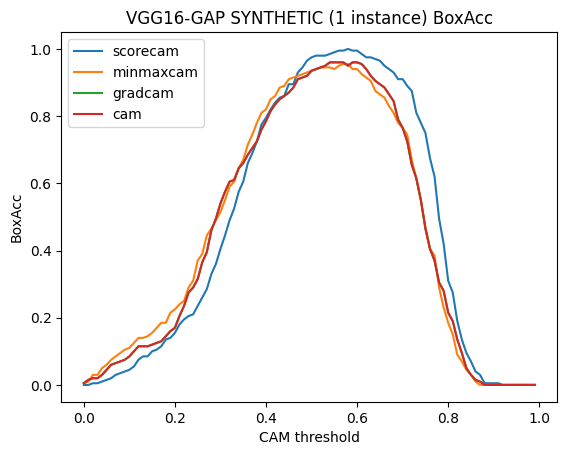

In [100]:
plot_boxacc(boxacc, title='VGG16-GAP SYNTHETIC (1 instance) BoxAcc')

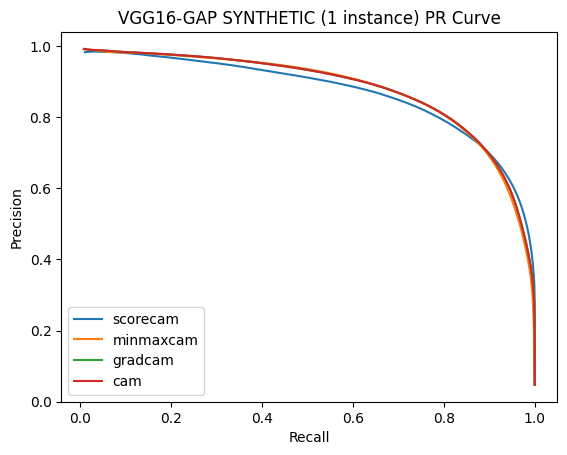

In [103]:
plot_prcurve(prcurve, 'VGG16-GAP SYNTHETIC (1 instance) PR Curve')

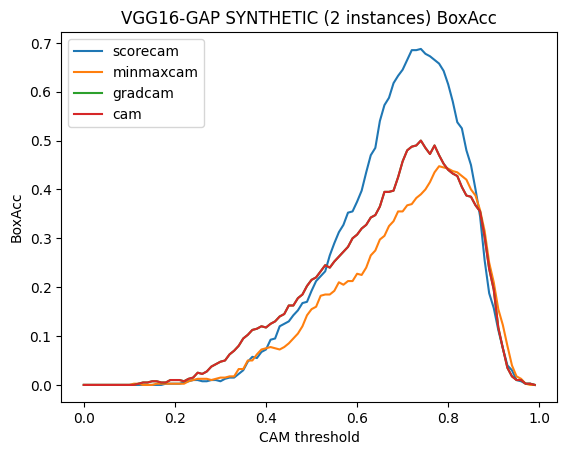

In [105]:
boxacc, prcurve = get_mlflow_boxacc_prcurve(dataset='SYNTHETIC', spec='d2b', archtype='cam')
plot_boxacc(boxacc, title='VGG16-GAP SYNTHETIC (2 instances) BoxAcc')

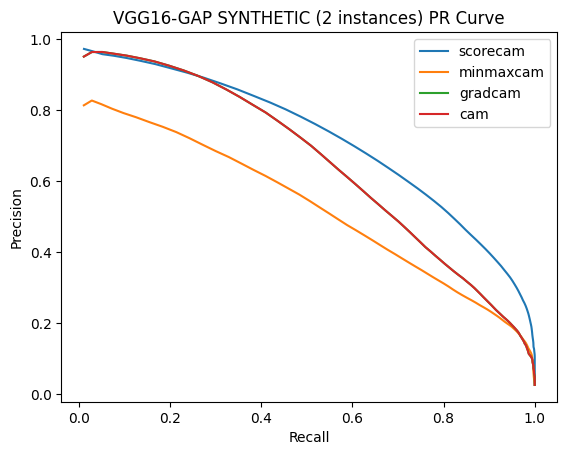

In [106]:
plot_prcurve(prcurve, title='VGG16-GAP SYNTHETIC (2 instances) PR Curve')

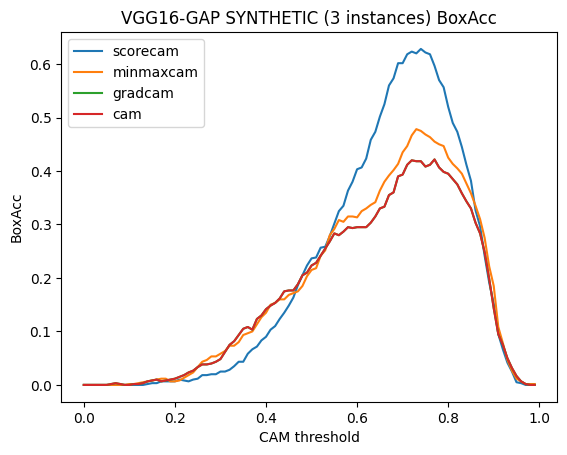

In [107]:
boxacc, prcurve = get_mlflow_boxacc_prcurve(dataset='SYNTHETIC', spec='d3b', archtype='cam')
plot_boxacc(boxacc, title='VGG16-GAP SYNTHETIC (3 instances) BoxAcc')

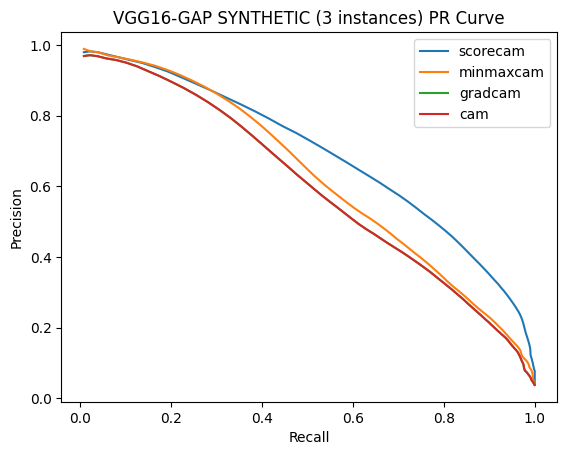

In [108]:
plot_prcurve(prcurve, title='VGG16-GAP SYNTHETIC (3 instances) PR Curve')

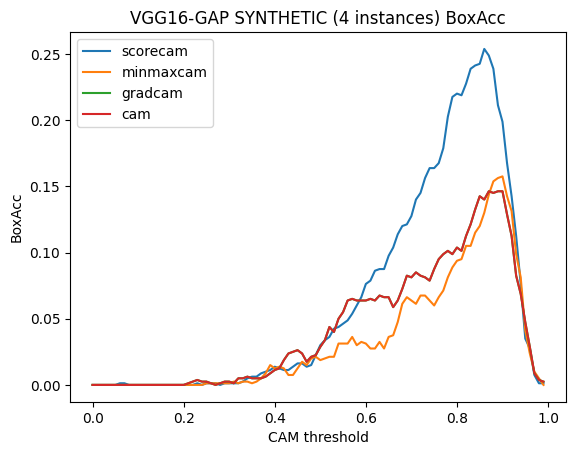

In [183]:
boxacc, prcurve = get_mlflow_boxacc_prcurve(dataset='SYNTHETIC', spec='d4b', archtype='cam')
plot_boxacc(boxacc, title='VGG16-GAP SYNTHETIC (4 instances) BoxAcc')

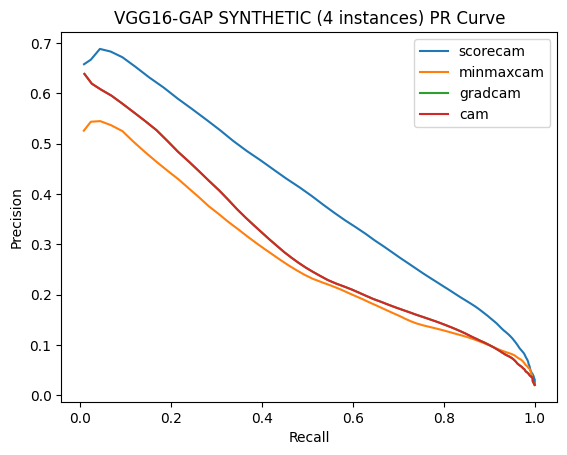

In [184]:
plot_prcurve(prcurve, title='VGG16-GAP SYNTHETIC (4 instances) PR Curve')

### Training performance

In [119]:
dataset = 'SYNTHETIC'
spec = 'o1t'
archtype = 'cam'
run_id = 'e6f2d6ba4ca24e31ba7b57c2e2d0266b'
filter_string = f'run_id = "{run_id}"'
runs = get_runs('wsol', filter_string=filter_string)

In [120]:
runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_MaxBoxAccV3_IOU_70,metrics.val_MaxBoxAccV3_IOU_30,metrics.val_MaxBoxAccV3_IOU_70,metrics.train_loss,...,tags.experiment,tags.dataset,tags.architecture,tags.mlflow.source.name,tags.mlflow.user,tags.num_classes,tags.mlflow.project.backend,tags.optimizer,tags.mlflow.log-model.history,tags.dataset_spec
0,e6f2d6ba4ca24e31ba7b57c2e2d0266b,444281214894994099,RUNNING,file:///Users/goemaereg/github.com/thesis/mlru...,2023-02-04 12:10:01.996000+00:00,2023-02-04 14:06:57.368000+00:00,0.19,0.995,0.165,0.00291,...,vgg16_gap_minmaxcam_synthetic_o1t,SYNTHETIC,vgg16,/file:///Users/goemaereg/github.com/thesis,root,9,local,SGD,"[{""run_id"": ""e6f2d6ba4ca24e31ba7b57c2e2d0266b""...",o1t


In [127]:
from mlflow import MlflowClient

client = MlflowClient()
val_accuracy = [metric.value for metric in client.get_metric_history(run_id, 'val_accuracy')]
steps = list(range(len(val_accuracy)))
val_maxboxaccv3 = [metric.value for metric in client.get_metric_history(run_id, 'val_MaxBoxAccV3')]
val_pxap = [metric.value for metric in client.get_metric_history(run_id, 'val_PxAP')]

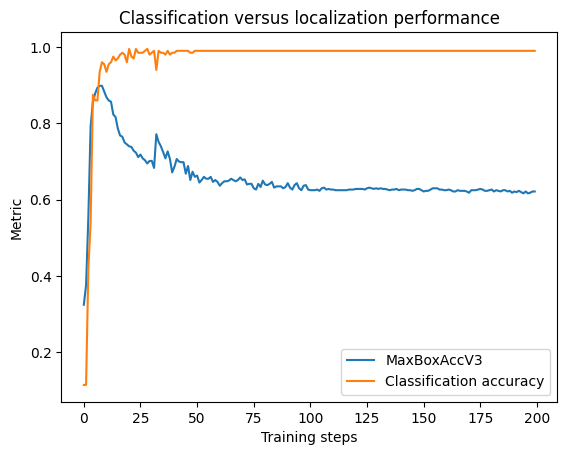

In [129]:
plt.plot(steps, val_maxboxaccv3, label = 'MaxBoxAccV3')
plt.plot(steps, val_accuracy, label='Classification accuracy')
plt.xlabel("Training steps")
plt.ylabel("Metric")
plt.title('Classification versus localization performance')
plt.legend()
plt.show()


In [137]:
iou_thresholds = [30, 50, 70]
boxacc_thresholds = {}
for threshold in iou_thresholds:
    boxacc, _ = get_mlflow_boxacc_prcurve(dataset='SYNTHETIC', spec='o1b', archtype='cam', iou_threshold=threshold)
    boxacc_thresholds |= {threshold: boxacc['cam']}

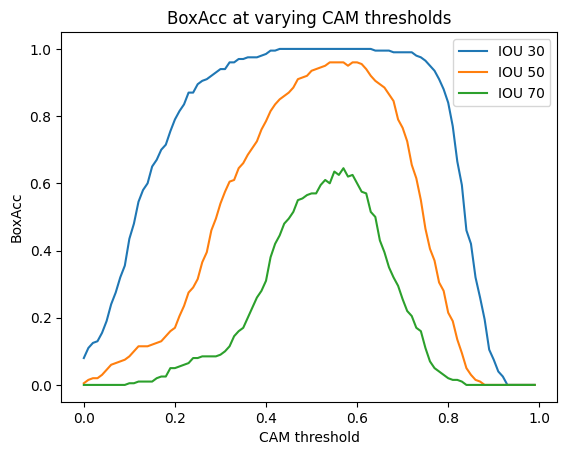

In [138]:
for threshold, values in boxacc_thresholds.items():
    label = f'IOU {threshold}'
    plt.plot(values['cam_threshold'], values['box_accuracy'], label = label)
plt.xlabel("CAM threshold")
plt.ylabel("BoxAcc")
plt.title('BoxAcc at varying CAM thresholds')
plt.legend()
plt.show()

In [152]:
def normalize_scoremap(cam):
    """
    Args:
        cam: numpy.ndarray(size=(H, W), dtype=np.float)
    Returns:
        numpy.ndarray(size=(H, W), dtype=np.float) between 0 and 1.
        If input array is constant, a zero-array is returned.
    """
    if np.isnan(cam).any():
        return np.zeros_like(cam)
    if cam.min() == cam.max():
        return np.zeros_like(cam)
    cam -= cam.min()
    cam /= cam.max()
    return cam

In [180]:
import numpy as np
import cv2

path_scoremap = '../val_log/vgg16_gap_cam_synthetic_d2b/scoremaps/test/SYNTHETIC_d_2_b_test_111.png.npy'
path_gtmask = '../data/maskdata/SYNTHETIC/d_2_b/test/SYNTHETIC_d_2_b_test_111.png'
path_image = '../data/dataset/SYNTHETIC/d_2_b/test/SYNTHETIC_d_2_b_test_111.png'
path_overlay = 'overlay.png'

image_shape = (512, 512, 3)
img = cv2.imread(path_image) # color channels in BGR format
scoremap = np.load(path_scoremap)
cam = cv2.resize(scoremap, image_shape[:2], interpolation=cv2.INTER_CUBIC)
cam = normalize_scoremap(cam)
cam_threshold_optimal = 0.74
cam_mask = cam >= cam_threshold_optimal

In [182]:
segment_cam = np.zeros(shape=image_shape)
segment_cam[cam_mask] = (0, 0, 255)  # BGR
segment_gt = np.zeros(shape=image_shape)
segment_gt_image = cv2.imread(path_gtmask) # color channels in BGR format
gt_mask = segment_gt_image > 0
segment_gt[gt_mask[:,:,0]] = (0, 255, 0)
image = segment_gt * 0.3 + segment_cam * 0.3 + img * 0.4
cv2.imwrite(path_overlay, image)

True